In [472]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

In [517]:
# clustering imports
from sklearn.cluster import AgglomerativeClustering

In [473]:
gene_info = pd.read_table('geneinfo_beta.txt')
sig_info = pd.read_table('siginfo_beta.txt', low_memory=False)

In [474]:
fil = gene_info['feature_space']=='landmark'
genes_lm = gene_info[fil]
genes_lm = genes_lm.set_index('gene_id', drop = True)['gene_symbol']
genes_lm.index = genes_lm.index.astype(str)


In [475]:
def map_gene_id_to_gene_symbol(genes_lm,signatures_lm):
    genes = genes_lm.copy()
    signatures = signatures_lm.copy()
    # map gene names of CRISPR signatures
    genes.index = genes.index.astype('int')
    signatures.index = signatures.index.map(genes.to_dict())
    return signatures

In [476]:
signatures_lm = pd.read_csv('signatures_lm_xpr.csv', index_col = 0)
signatures_lm_xpr_mapped = map_gene_id_to_gene_symbol(genes_lm, signatures_lm)

In [477]:
signatures_lm = pd.read_csv('signatures_lm_oe.csv', index_col = 0)
signatures_lm_oe_mapped = map_gene_id_to_gene_symbol(genes_lm, signatures_lm)

In [478]:
signatures_lm = pd.read_csv('signatures_lm_sh.csv', index_col = 0)
signatures_lm_sh_mapped = map_gene_id_to_gene_symbol(genes_lm, signatures_lm)

In [713]:
reactions = pd.read_csv('sasaki_reactions_data.csv', index_col =0)

# Heatmaps

In [479]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)


In [480]:
metadata = pd.read_csv('sasaki_data.csv', index_col = 0)
metadata = metadata.set_index('GeneSymbol', drop=True)

In [481]:
kinases = list(metadata[metadata['Function'] == 'kinase'].index)
phosphatases = list(metadata[metadata['Function'] == 'phosphatase'].index)

In [482]:
def select_genes(signatures_lm, list_of_genes):
    selected_genes = []
    for gene in list_of_genes:
        if gene in signatures_lm.columns:
            selected_genes.append(gene)
    selected = list(np.intersect1d(list_of_genes, selected_genes))
    return selected

In [483]:
def calculate_similarity(signatures, genes_selected):
    similarities = pd.DataFrame(index = genes_selected, columns = genes_selected)
    for gene in genes_selected:
        for ko in genes_selected:
            similarities.loc[gene, ko] = spearmanr(signatures[gene], signatures[ko])[0]
    similarities = similarities.astype('float')
    return similarities

In [799]:
class_colors = dict(zip(metadata['Class'].unique(),
                      list(reversed(sns.color_palette("Spectral", len(metadata['Class'].unique()))))))

In [800]:
def plot_clustermap(simialrities, title, figsize = (8,8)):
    
    col_colors = pd.DataFrame(metadata[metadata.index.isin(simialrities.columns)]['Class'].map(class_colors))
    g = sns.clustermap(simialrities)
    plt.close()
    masks = ~np.triu(np.ones_like(simialrities, dtype=bool))
    masks = masks[np.argsort(g.dendrogram_row.reordered_ind),:]
    masks = masks[:,np.argsort(g.dendrogram_col.reordered_ind)]
    g = sns.clustermap(simialrities,  cmap = cmap,  center=0, mask = masks, vmax = .6, figsize=figsize, 
                       col_colors = col_colors
                      )
    plt.title(title, fontsize = 14)

    ax = g.ax_heatmap
    ax.xaxis.tick_top()
    ax.tick_params(axis='x', labelrotation=45)
    g.ax_row_dendrogram.remove()


In [801]:
class_colors_to_df = dict(zip(metadata['Class'].unique(),
                      list(reversed(sns.color_palette("Spectral", len(metadata['Class'].unique())).as_hex()))))

In [802]:
class_colors_df = pd.DataFrame(index = class_colors_to_df.keys(), columns = ['color'])
class_colors_df['color'] = class_colors_to_df.values()

In [488]:
class_colors_df.style.applymap(lambda x: 'background-color: %s' % x)

,color
Phosphoinositide 3-kinases,#3d95b8
Phosphatidylinositol 4-kinases,#86cfa5
Phosphatidylinositol phosphate kinases,#d6ee9b
Phosphoinositide 3-phosphatases,#ffffbe
Phosphoinositide 4-phosphatases,#fed481
Phosphoinositide 5-phosphatases,#f98e52
Other phosphatases,#dd4a4c


# PLOTS

## XPR

In [701]:
kinases_selected = select_genes(signatures_lm_xpr_mapped, kinases)
similarities_kinases = calculate_similarity(signatures_lm_xpr_mapped, kinases_selected)

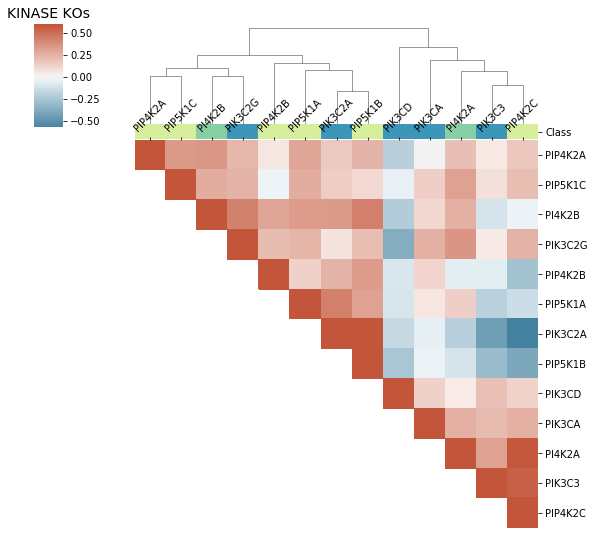

In [702]:
plot_clustermap(similarities_kinases, title = 'KINASE KOs')

In [703]:
model = AgglomerativeClustering(linkage='average', n_clusters=2)
clusters = pd.Series(model.fit_predict(similarities_kinases),index=similarities_kinases.columns).sort_values()

In [704]:
clusters_ko_kinase = pd.DataFrame(clusters, columns = ['cluster'], index = clusters.index)

In [705]:
phosphatases_selected = select_genes(signatures_lm_xpr_mapped, phosphatases)
similarities_phosphatases = calculate_similarity(signatures_lm_xpr_mapped, phosphatases_selected)

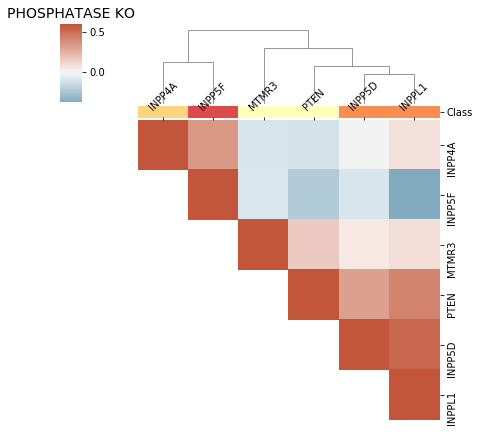

In [706]:
plot_clustermap(similarities_phosphatases, title = 'PHOSPHATASE KO', figsize = (6,6))

In [707]:
# XPR ALL

In [708]:
genes_selected = select_genes(signatures_lm_xpr_mapped, kinases+phosphatases)
similarities_all = calculate_similarity(signatures_lm_xpr_mapped, genes_selected)

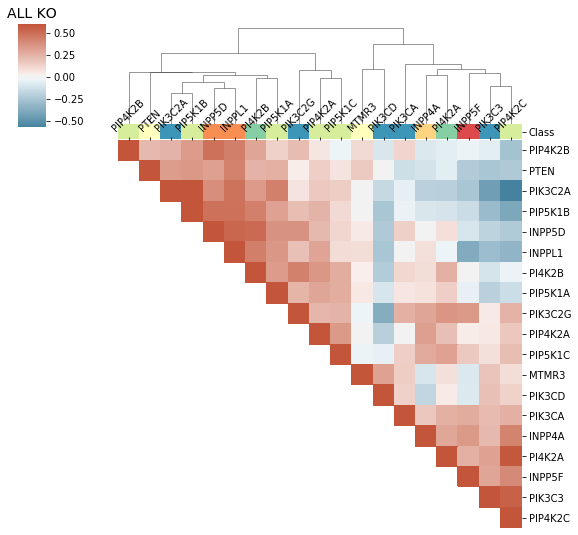

In [709]:
plot_clustermap(similarities_all, title = 'ALL KO', figsize = (8,8))

In [710]:
model = AgglomerativeClustering(linkage='average', n_clusters=2)
clusters = pd.Series(model.fit_predict(similarities_all),index=similarities_all.columns).sort_values()

In [767]:
def select_reactions_from_cluster(clusters, cluster):
    reactions = metadata.loc[clusters[clusters == cluster].index].Reaction
    return set([item for sublist in reactions for item in sublist if item.isalpha()])

In [768]:
select_reactions_from_cluster(clusters, 1)

{'A', 'B', 'E', 'H', 'I', 'a', 'j', 'l'}

## SH

In [537]:
kinases_selected = select_genes(signatures_lm_sh_mapped, kinases)
similarities_kinases = calculate_similarity(signatures_lm_sh_mapped, kinases_selected)

In [1]:
# plot_clustermap(similarities_kinases, title = 'KINASE KDs')

In [539]:
model = AgglomerativeClustering(linkage='average', n_clusters=2)
clusters = pd.Series(model.fit_predict(similarities_kinases),index=similarities_kinases.columns).sort_values()

In [542]:
clusters_sh_kinase = pd.DataFrame(clusters, columns = ['cluster'], index = clusters.index)

In [495]:
phosphatases_selected = select_genes(signatures_lm_sh_mapped, phosphatases)
similarities_phosphatases = calculate_similarity(signatures_lm_sh_mapped, phosphatases_selected)

In [2]:
# plot_clustermap(similarities_phosphatases, title = 'PHOSPHATASE KDs', figsize = (6,6))

# OE

In [776]:
kinases_selected = select_genes(signatures_lm_oe_mapped, kinases)
similarities_kinases = calculate_similarity(signatures_lm_oe_mapped, kinases_selected)

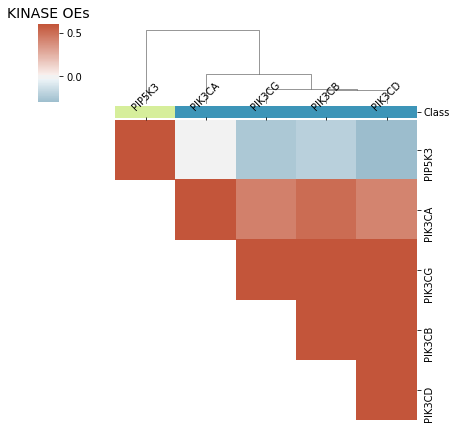

In [777]:
plot_clustermap(similarities_kinases, title = 'KINASE OEs', figsize = (6,6))

In [778]:
phosphatases_selected = select_genes(signatures_lm_oe_mapped, phosphatases)
similarities_phosphatases = calculate_similarity(signatures_lm_oe_mapped, phosphatases_selected)

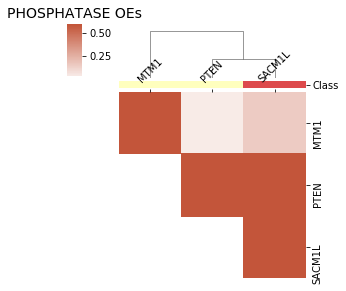

In [779]:
plot_clustermap(similarities_phosphatases, title = 'PHOSPHATASE OEs', figsize = (4,4))

In [ ]:
# OE ALL

In [783]:
genes_selected = select_genes(signatures_lm_oe_mapped, kinases+phosphatases)
similarities_all = calculate_similarity(signatures_lm_oe_mapped, genes_selected)

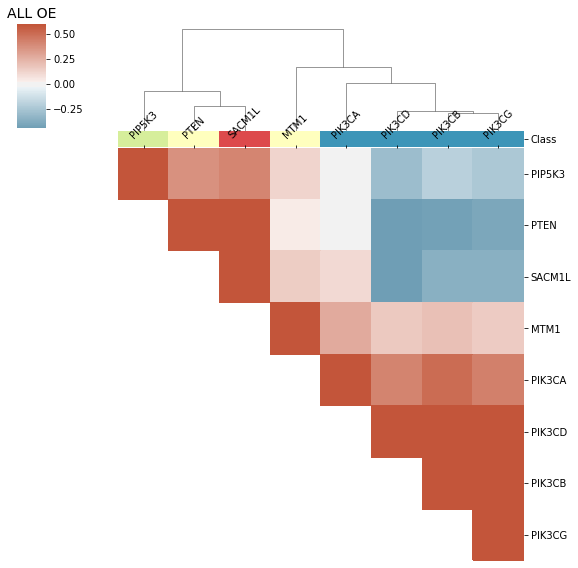

In [784]:
plot_clustermap(similarities_all, title = 'ALL OE', figsize = (8,8))

In [785]:
model = AgglomerativeClustering(linkage='average', n_clusters=2)
clusters = pd.Series(model.fit_predict(similarities_all),index=similarities_all.columns).sort_values()

In [789]:
select_reactions_from_cluster(clusters, 1)

{'C', 'F', 'a', 'b', 'f', 'l'}

In [788]:
clusters

MTM1      0
PIK3CA    0
PIK3CB    0
PIK3CD    0
PIK3CG    0
PIP5K3    1
PTEN      1
SACM1L    1
dtype: int64

In [792]:
metadata.loc[clusters[clusters == 1].index]

,Function,Class,Subclass,Reaction
PIP5K3,kinase,Phosphatidylinositol phosphate kinases,III,"('F', 'C')"
PTEN,phosphatase,Phosphoinositide 3-phosphatases,PTEN,"('l', 'a')"
SACM1L,phosphatase,Other phosphatases,Sac,"('a', 'b', 'f')"


# Quality control 

In [501]:
def plot_correlation_between_common_genes(signatures1, signatures2, plus_selected_genes = []):
    if len(plus_selected_genes) == 0: plus_selected_genes = signatures1.columns
    common_genes = reduce(np.intersect1d, [signatures1.columns, signatures2.columns, plus_selected_genes])
    correlations = pd.Series(index = common_genes, dtype = 'float')
    for gene in common_genes:
        correlations[gene] = spearmanr(signatures1[gene], signatures2[gene])[0]
    if correlations.shape[0] > 2: plt.hist(correlations)
    return correlations

PIK3CA    0.149348
PIK3CD    0.310117
PTEN      0.232862
dtype: float64

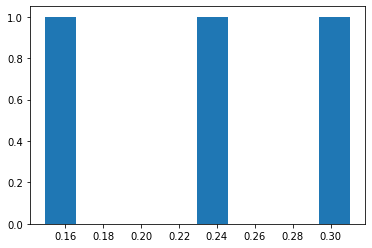

In [502]:
plot_correlation_between_common_genes(signatures_lm_xpr_mapped, signatures_lm_oe_mapped, phosphatases+kinases)

PIK3CA    0.340614
PIK3CB    0.018546
PIK3CD    0.054457
PIK3CG   -0.226993
PTEN      0.004708
SACM1L    0.272988
dtype: float64

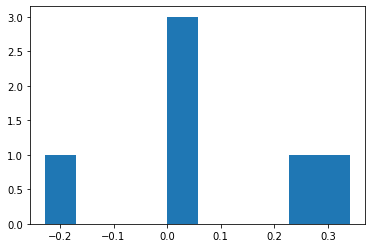

In [503]:
plot_correlation_between_common_genes(signatures_lm_sh_mapped, signatures_lm_oe_mapped, phosphatases+kinases)

PI4K2B    -0.269157
PIK3C2A   -0.213984
PIK3CD    -0.089258
PI4K2A    -0.074543
PIP5K1C   -0.057278
PIP4K2A   -0.046059
PIK3C2G   -0.027188
INPPL1    -0.005199
PTEN       0.097564
PIP4K2C    0.101820
PIP4K2B    0.216745
PIK3CA     0.251414
PIP5K1B    0.260108
PIK3C3     0.382243
INPP5D     0.504571
dtype: float64

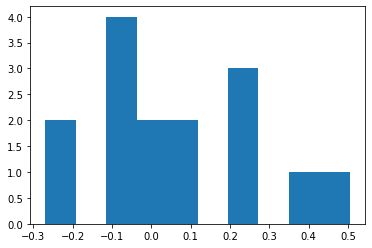

In [504]:
plot_correlation_between_common_genes(signatures_lm_sh_mapped, signatures_lm_xpr_mapped, phosphatases+kinases).sort_values()

# Examine OE, SH and XPR together - only common

In [696]:
def calculate_similarity_between_two_signatures(oe_signatures, xpr_signatures):
    correlations = pd.DataFrame(index = xpr_signatures.columns, columns = oe_signatures.columns)
    for oe in oe_signatures.columns:
        for xpr in xpr_signatures.columns:
            correlations.loc[xpr, oe] = spearmanr(oe_signatures[oe], xpr_signatures[xpr])[0]
    correlations = correlations.astype('float')
    return correlations

In [688]:
def plot_clustermap_total(simialrities, title, figsize = (8,8)):
    genes = set(simialrities.columns) | set(simialrities.index)
    col_colors = pd.DataFrame(metadata[metadata.index.isin(genes)]['Class'].map(class_colors))
    g = sns.clustermap(simialrities,  
                       cmap = cmap,  
                       center=0, 
                       figsize=figsize, 
                       col_colors = col_colors,
                      row_colors = col_colors)
    plt.title(title, fontsize = 14)
    ax = g.ax_heatmap
    ax.tick_params(axis='x', labelrotation=45)

In [632]:
xpr_selected = signatures_lm_xpr_mapped.loc[:, select_genes(signatures_lm_xpr_mapped, kinases+phosphatases)]
oe_selected = signatures_lm_oe_mapped.loc[:, select_genes(signatures_lm_oe_mapped, kinases+phosphatases)]
sh_selected = signatures_lm_sh_mapped.loc[:, select_genes(signatures_lm_sh_mapped, kinases+phosphatases)]

In [697]:
simialrities_oe_xpr = calculate_similarity_between_two_signatures(oe_selected, xpr_selected)

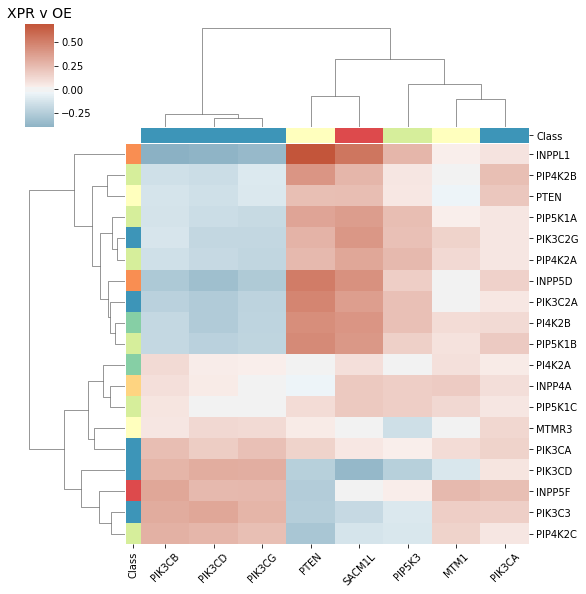

In [698]:
plot_clustermap_total(simialrities_oe_xpr, title = 'XPR v OE')

In [699]:
simialrities_oe_sh = calculate_similarity_between_two_signatures(oe_selected, sh_selected)

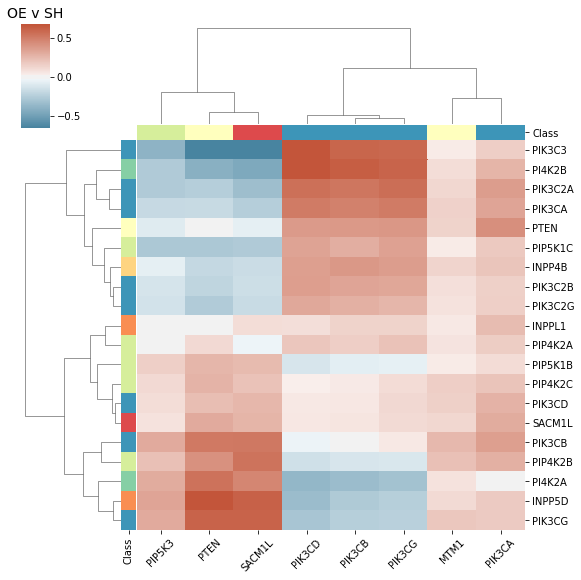

In [793]:
plot_clustermap_total(simialrities_oe_sh, title = 'OE v SH')